# WEB SCRAPING WORKFLOW

In [1]:
# ===============================================================
# IMPORTS
# ===============================================================

import requests                      # For HTTP requests
from bs4 import BeautifulSoup        # For parsing HTML
import pandas as pd                  # For tabular data handling
import random
import io
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
# ===============================================================
# INPUTS
# ===============================================================
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"
timeout = 10 # Seconds to wait for the client to make a connection and/or send a response
num_char_to_rpint = 500 # Nubmer of characters to print from HTML
no_tables_to_preview = 3
database_name = "my_database.db"
sql_table_name = "Spotify_most_streamed_songs"

In [3]:
# ===============================================================
# LIST OF USER - AGENTS
# ===============================================================
user_agents = [
    # Chrome Windows
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
    "AppleWebKit/537.36 (KHTML, like Gecko) "
    "Chrome/121.0.0.0 Safari/537.36",

    # Chrome macOS
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) "
    "AppleWebKit/537.36 (KHTML, like Gecko) "
    "Chrome/120.0.0.0 Safari/537.36",

    # Firefox Windows
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:122.0) "
    "Gecko/20100101 Firefox/122.0",

    # Firefox Linux
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:121.0) "
    "Gecko/20100101 Firefox/121.0",

    # Edge Windows
    "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
    "AppleWebKit/537.36 (KHTML, like Gecko) "
    "Chrome/120.0.0.0 Safari/537.36 Edg/120.0.0.0",

    # Safari Mac
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 13_3_1) "
    "AppleWebKit/605.1.15 (KHTML, like Gecko) "
    "Version/16.4 Safari/605.1.15",
]

In [4]:
# ===============================================================
# HELPER FUNCTIONS
# ===============================================================

# HTTP Header generator
def generate_browser_headers():
    headers = {
        "User-Agent": random.choice(user_agents),               # Identifies browser & system
        "Accept": (
            "text/html,application/xhtml+xml,application/xml;"
            "q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8"
        ),
        "Accept-Language": "en-US,en;q=0.9",                    # Browser language preference
        "Accept-Encoding": "gzip, deflate, br",                 # Compression support
        "Connection": "keep-alive",                             # Prevents reconnection overhead

        # Modern browser metadata (Chrome/Edge)
        "Sec-Fetch-Dest": "document",                           # Type of resource being fetched
        "Sec-Fetch-Mode": "navigate",                           # Indicates navigation request
        "Sec-Fetch-Site": "none",                               # Origin relationship
        "Sec-Fetch-User": "?1",                                 # User-initiated request

        # Standard browser referer
        "Referer": "https://www.google.com/",                   # Reduces suspicion
    }
    return headers

# Generates n distinct browser-like header sets that can be used as fallback options when servers block multiple requests
def get_rotating_headers(n: int = 5):
    rotated_headers = []
    for i in range(n):
        rotated_headers.append(generate_browser_headers())
    return rotated_headers

# Parses raw HTML into a BeautifulSoup object
def parse_html(html_text: str):
    return BeautifulSoup(html_text, "html.parser")

# Convert a DataFrame column name into a SQL-safe name by removing/replacing characters that break SQL syntax
def normalize_column_name(col):
    col = col.strip()                      # remove leading/trailing spaces
    col = col.replace(" ", "_")            # replace spaces with underscores
    col = re.sub(r"[^\w]", "_", col)       # replace non-alphanumeric with underscores
    col = re.sub(r"_+", "_", col)          # collapse multiple underscores
    return col

# Convert a pandas dtype to a general SQL type
def pandas_type_to_sql(dtype):
    dtype_str = str(dtype).lower()
    # INTEGER TYPES
    if "int" in dtype_str:
        if "int8" in dtype_str:
            return "TINYINT"
        elif "int16" in dtype_str:
            return "SMALLINT"
        elif "int32" in dtype_str:
            return "INTEGER"
        elif "int64" in dtype_str:
            return "BIGINT"
        return "INTEGER"
    # FLOATING TYPES
    if "float" in dtype_str:
        if "float16" in dtype_str:
            return "REAL"
        elif "float32" in dtype_str:
            return "FLOAT"
        elif "float64" in dtype_str:
            return "DOUBLE"
        return "REAL"
    # DECIMAL / NUMERIC TYPES
    if "decimal" in dtype_str or "numeric" in dtype_str:
        return "DECIMAL"
    # BOOLEAN
    if "bool" in dtype_str:
        return "BOOLEAN"
    # DATE / TIME TYPES
    if "datetime" in dtype_str:
        return "TIMESTAMP"
    if "date" in dtype_str:
        return "DATE"
    if "timedelta" in dtype_str:
        return "INTERVAL"
    if "time" in dtype_str:
        return "TIME"
    # STRING / TEXT / OBJECT
    if "string" in dtype_str:
        return "VARCHAR(255)"
    if "object" in dtype_str:
        return "TEXT"
    # CATEGORICAL
    if "category" in dtype_str:
        return "VARCHAR(255)"
    # BINARY TYPES
    if "bytes" in dtype_str or "binary" in dtype_str:
        return "BLOB"
    # FALLBACK
    return "TEXT"

# Check if table exists in SQL database
def table_exists(cursor, table_name: str):
    cursor.execute("""
        SELECT name FROM sqlite_master 
        WHERE type='table' AND name=?;
    """, (table_name,))
    return cursor.fetchone() is not None

# Check if a full row already exists in the table
def row_exists(cursor, table_name: str, columns: list, row_values: list):
    # Build WHERE clause step by step
    conditions = []
    for col in columns:
        condition = f"{col}=?"
        conditions.append(condition)
    # Join conditions with AND
    where_clause = " AND ".join(conditions)
    sql = f"SELECT 1 FROM {table_name} WHERE {where_clause} LIMIT 1;"
    cursor.execute(sql, row_values)
    return cursor.fetchone() is not None

# Build an automatic CREATE table SQL statement
def generate_CREATE_TABLE_statement(df: pd.DataFrame, table_name: str, primary_key=None, autoincrement=False):
    columns_sql = []
    for col in df.columns:
        sql_type = pandas_type_to_sql(df[col].dtype)
        # Mark primary key column
        if col == primary_key:
            if autoincrement:
                columns_sql.append(f"    {col} {sql_type} PRIMARY KEY AUTOINCREMENT")
            else:
                columns_sql.append(f"    {col} {sql_type} PRIMARY KEY")
        else:
            columns_sql.append(f"    {col} {sql_type}")
    # Join all column definitions
    columns_sql = ",\n".join(columns_sql)
    # Final CREATE TABLE statement
    create_table = f"CREATE TABLE IF NOT EXISTS {table_name} (\n{columns_sql}\n);"
    return create_table

# Build an automatic INSERT SQL statement
def generate_INSERT_statement(df: pd.DataFrame, table_name: str):
    placeholders = ", ".join(["?"] * len(df.columns))
    columns_sql = ", ".join(df.columns)
    insert = f"INSERT INTO {sql_table_name} ({columns_sql}) VALUES ({placeholders});"
    return insert

# Build an automatic SELECT SQL statement
def generate_SELECT_statement(table_name: str):
    select_sql = f"SELECT * FROM {table_name};"
    return select_sql

In [5]:
# ===============================================================
# STEP 1 — DOWNLOAD RESOURCE
# ===============================================================
print("==============================================")
print("STEP 1 — DOWNLOAD RESOURCE")
print("==============================================\n")

# 1) Build headers list
headers_list = get_rotating_headers(5)

# 2) Test the connection and retrieve HTML
for header in headers_list:
    try:
        response = requests.get(url=url, headers=header, timeout=timeout)
        if response.ok:
            html_text = response.text
            print("✅ Successfull response with header:", header["User-Agent"])
            print("✅ Response Status code: " + str(response.status_code))
            break
    except:
        print("⛔ Unsuccessfull response with header:", header["User-Agent"])
        print("⛔ Response Status code: " + str(response.status_code))
        continue

# 3) Check the html has content
if html_text is None:
    raise ValueError("⛔ Download failed, fix the URL and/or connection and try again")
else:
    print("✅ Raw HTML downloaded successfully")
    print("🔍 HTML preview:")
    print("----------------------------------------")
    print(html_text[:num_char_to_rpint])

STEP 1 — DOWNLOAD RESOURCE

✅ Successfull response with header: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:121.0) Gecko/20100101 Firefox/121.0
✅ Response Status code: 200
✅ Raw HTML downloaded successfully
🔍 HTML preview:
----------------------------------------
<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vect


In [6]:
# ===============================================================
# STEP 2 — PARSE HTML TO GET INFORMATION ABOUT PAGE STRUCTURE
# ===============================================================
print("\n==============================================")
print("STEP 2 — PARSE HTML TO GET STRUCTURE INFORMATION")
print("==============================================\n")

# 1) Parse the HTML using BeautifulSoup
soup = parse_html(html_text=html_text)
print("✅ HTML successfully parsed using BeautifulSoup")

# 2) Count all tags in the document
all_tags= []
for tag in soup.find_all():
    all_tags.append(tag.name)
print("🏷️ Total tags found:", len(all_tags))

# 3) Compute frequency of each tag
tag_freq = pd.Series(all_tags).value_counts()
print("🏷️ Total distinct tag types found:", tag_freq.shape[0])

# 4) Detect <table> tags
tables = soup.find_all("table")
num_tables = len(tables)
if num_tables == 0:
        print("⚠️ No tables found in the HTML.")
else:
    print("🧮 Number of tables found on this page:", num_tables)
    print("🧮 Table classes found:")
    for i, table in enumerate(tables):
        print(f"        Table {i}: {table.get('class')}")


STEP 2 — PARSE HTML TO GET STRUCTURE INFORMATION

✅ HTML successfully parsed using BeautifulSoup
🏷️ Total tags found: 11677
🏷️ Total distinct tag types found: 47
🧮 Number of tables found on this page: 27
🧮 Table classes found:
        Table 0: ['wikitable', 'sortable', 'plainrowheaders']
        Table 1: ['wikitable', 'sortable;']
        Table 2: ['wikitable', 'sortable']
        Table 3: ['wikitable']
        Table 4: ['wikitable', 'sortable', 'plainrowheaders']
        Table 5: ['wikitable']
        Table 6: ['wikitable']
        Table 7: ['wikitable', 'sortable']
        Table 8: ['wikitable', 'sortable']
        Table 9: ['wikitable']
        Table 10: ['wikitable', 'sortable']
        Table 11: ['wikitable', 'sortable']
        Table 12: ['wikitable']
        Table 13: ['wikitable', 'sortable']
        Table 14: ['wikitable', 'sortable']
        Table 15: ['wikitable']
        Table 16: ['wikitable', 'sortable']
        Table 17: ['wikitable', 'sortable']
        Table 18: ['wik

In [7]:
# ===============================================================
# STEP 3 — LOAD TABLES INTO DATAFRAMES
# ===============================================================
print("\n==============================================")
print("STEP 3 — LOAD TABLES INTO DATAFRAMES")
print("==============================================\n")

if num_tables > 0:
    try:
        df_list = pd.read_html(io.StringIO(html_text))
        for i, df in enumerate(df_list): # Create variables automatically to store each table:
            var_name = f"df_table_{i}"
            globals()[var_name] = df
        print(f"✅ Successfully loaded {len(df_list)} table(s) into DataFrames")
        print(f"🔍 Preview of first {no_tables_to_preview} tables:")
        for i in range(no_tables_to_preview):
            display(globals()["df_table_" + str(i)].head())

    except ValueError:
        print("❌ pandas.read_html() could not parse any table")
else:
    print("❌ No tables available to load into DataFrames")



STEP 3 — LOAD TABLES INTO DATAFRAMES

✅ Successfully loaded 27 table(s) into DataFrames
🔍 Preview of first 3 tables:


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.145,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.651,6 January 2017,[2]
2,3,"""Starboy""",The Weeknd and Daft Punk,4.213,21 September 2016,[3]
3,4,"""Sweater Weather""",The Neighbourhood,4.188,3 December 2012,[4]
4,5,"""Someone You Loved""",Lewis Capaldi,4.135,8 November 2018,[5]


Rank         Artist     Top 100            Top 10       3 billion+ streams  \
  Rank         Artist Total songs Lead Feat.   Lead Feat.               Lead   
0    1     Bruno Mars           6    5     1    NaN   NaN                  1   
1    2     The Weeknd           5    5   NaN      2   NaN                  1   
2    3     Ed Sheeran           4    4   NaN      2   NaN                  2   
3    3       Coldplay           4    3     1    NaN   NaN                  2   
4    3  Justin Bieber           4    3     1    NaN     1                NaN   

        4 billion+ streams       5 billion+ streams        
  Feat.               Lead Feat.               Lead Feat.  
0   NaN                NaN   NaN                NaN   NaN  
1   NaN                  1   NaN                  1   NaN  
2   NaN                  1   NaN                NaN   NaN  
3     1                NaN   NaN                NaN   NaN  
4     1                NaN   NaN                NaN   NaN

,No.,Song,Artist(s),Streams (billions),Release date,Date achieved,Days held,Ref.,Notes
0,9,"""Blinding Lights""",The Weeknd,3.332,29 November 2019,1 January 2023,1055,[98],NaN
1,8,"""Shape of You""",Ed Sheeran,1.318,6 January 2017,21 September 2017,1928,[99],NaN
2,7,"""One Dance""",Drake featuring Wizkid and Kyla,0.882,5 April 2016,18 October 2016,338,[100],NaN
3,6,"""Lean On""",Major Lazer featuring MØ and DJ Snake,0.526,2 March 2015,11 November 2015,342,[101],NaN
4,5,"""Thinking out Loud""",Ed Sheeran,0.355,21 June 2014,22 May 2015,173,[102],NaN


In [8]:
# ===============================================================
# STEP 4 — CLEAN TABLE
# ===============================================================
print("\n==============================================")
print("STEP 4 — CLEAN TABLE")
print("==============================================\n")

# Copy original DataFrame
selected_df = df_table_0.copy()

# Save original DataFrame
original_df = selected_df

# Clean last row
selected_df = selected_df.iloc[:-1]

# Clean last column
selected_df = selected_df.iloc[:,:-1]

# Convert type
selected_df["Streams (billions)"]=selected_df["Streams (billions)"].astype(float)

# Normalize column names to SQL syntax
for col in selected_df.columns:
    safe_col = normalize_column_name(col)
    print(col,safe_col)
    selected_df.rename(columns={col: safe_col}, inplace=True)

# Print results
print(f" - ℹ️ Previous DataFrame:")
display(original_df)
print(f" - ℹ️ Current DataFrame:")
display(selected_df)


STEP 4 — CLEAN TABLE

Rank Rank
Song Song
Artist(s) Artist_s_
Streams (billions) Streams_billions_
Release date Release_date
 - ℹ️ Previous DataFrame:


,Rank,Song,Artist(s),Streams (billions),Release date,Ref.
0,1,"""Blinding Lights""",The Weeknd,5.145,29 November 2019,[1]
1,2,"""Shape of You""",Ed Sheeran,4.651,6 January 2017,[2]
2,3,"""Starboy""",The Weeknd and Daft Punk,4.213,21 September 2016,[3]
3,4,"""Sweater Weather""",The Neighbourhood,4.188,3 December 2012,[4]
4,5,"""Someone You Loved""",Lewis Capaldi,4.135,8 November 2018,[5]
...,...,...,...,...,...,...
96,97,"""Someone Like You""",Adele,2.458,24 January 2011,NaN
97,98,"""Levitating""",Dua Lipa and DaBaby,2.457,1 October 2020,[96]
98,99,"""Sad!""",XXXTentacion,2.457,2 March 2018,[97]
99,100,"""Payphone""",Maroon 5 and Wiz Khalifa,2.445,16 April 2012,NaN


 - ℹ️ Current DataFrame:


,Rank,Song,Artist_s_,Streams_billions_,Release_date
0,1,"""Blinding Lights""",The Weeknd,5.145,29 November 2019
1,2,"""Shape of You""",Ed Sheeran,4.651,6 January 2017
2,3,"""Starboy""",The Weeknd and Daft Punk,4.213,21 September 2016
3,4,"""Sweater Weather""",The Neighbourhood,4.188,3 December 2012
4,5,"""Someone You Loved""",Lewis Capaldi,4.135,8 November 2018
...,...,...,...,...,...
95,96,"""Lean On""",Major Lazer with DJ Snake and M∅,2.486,2 March 2015
96,97,"""Someone Like You""",Adele,2.458,24 January 2011
97,98,"""Levitating""",Dua Lipa and DaBaby,2.457,1 October 2020
98,99,"""Sad!""",XXXTentacion,2.457,2 March 2018


In [9]:
# ===============================================================
# STEP 5 — STORE DATA IN SQL
# ===============================================================
print("\n==============================================")
print("STEP 5 — STORE DATA IN SQL")
print("==============================================\n")

primary_key="Rank"

# Connect to database
con = sqlite3.connect(database=database_name)
cursor = con.cursor()

# CREATE TABLE if non existing
sql_CREATE_TABLE_statement = generate_CREATE_TABLE_statement(df=selected_df, table_name=sql_table_name, primary_key=primary_key, autoincrement=False)
if table_exists(cursor=cursor, table_name=sql_table_name):
    print(f"⚠️ Table '{sql_table_name}' already exists —> creation skipped")
else:
    try:
        cursor.execute(sql_CREATE_TABLE_statement)
        con.commit()
        print(f"✅ Table '{sql_table_name}' successfully created.")
    except Exception as e:
        print("❌ ERROR creating table:")
        print(e)

df_columns = list(selected_df.columns)

# INSERT INTO TABLE
sql_INSERT_statement = generate_INSERT_statement(df=selected_df, table_name=sql_table_name)

rows_inserted = 0
rows_skipped = 0

# Convert DataFrame to list-of-lists for cleaner iteration
data_rows = selected_df.values.tolist()

# Index of primary key "Rank"
pk_index = selected_df.columns.get_loc(primary_key)

# Loop using a normal index-based loop
for i in range(len(data_rows)):
    # Check if full row already exists
    if row_exists(cursor, sql_table_name, df_columns, data_rows[i]):
        print(f"⚠️ Skipped row {i} — identical row already exists")
        rows_skipped += 1
        continue
    try:
        cursor.execute(sql_INSERT_statement, data_rows[i])
        rows_inserted += 1
    except Exception as e:
        print(f"❌ ERROR inserting row {i}: {e}")

# Final commit
con.commit()

print(f"ℹ️ Rows inserted: {rows_inserted}")
print(f"ℹ️ Rows skipped: {rows_skipped}")

# Generate SELECT statement
sql_SELECT_statement = generate_SELECT_statement(table_name=sql_table_name)
# Execute query
cursor.execute(sql_SELECT_statement)

# Get column names from cursor.description
description = cursor.description
column_names = []

for col in description:
    column_names.append(col[0])

# Fetch all rows
rows = cursor.fetchall()

# Print result rows
for row in rows:
    print("---- ROW ----")
    for i in range(len(column_names)):
        col_name = column_names[i]
        value = row[i]
        print(f"{col_name} = {value}")
    print()


STEP 5 — STORE DATA IN SQL

✅ Table 'Spotify_most_streamed_songs' successfully created.
ℹ️ Rows inserted: 100
ℹ️ Rows skipped: 0
---- ROW ----
Rank = 1
Song = "Blinding Lights"
Artist_s_ = The Weeknd
Streams_billions_ = 5.145
Release_date = 29 November 2019

---- ROW ----
Rank = 2
Song = "Shape of You"
Artist_s_ = Ed Sheeran
Streams_billions_ = 4.651
Release_date = 6 January 2017

---- ROW ----
Rank = 3
Song = "Starboy"
Artist_s_ = The Weeknd and Daft Punk
Streams_billions_ = 4.213
Release_date = 21 September 2016

---- ROW ----
Rank = 4
Song = "Sweater Weather"
Artist_s_ = The Neighbourhood
Streams_billions_ = 4.188
Release_date = 3 December 2012

---- ROW ----
Rank = 5
Song = "Someone You Loved"
Artist_s_ = Lewis Capaldi
Streams_billions_ = 4.135
Release_date = 8 November 2018

---- ROW ----
Rank = 6
Song = "As It Was"
Artist_s_ = Harry Styles
Streams_billions_ = 4.124
Release_date = 1 April 2022

---- ROW ----
Rank = 7
Song = "Sunflower"
Artist_s_ = Post Malone and Swae Lee
Streams


STEP 6 - DATA VISUALIZATION



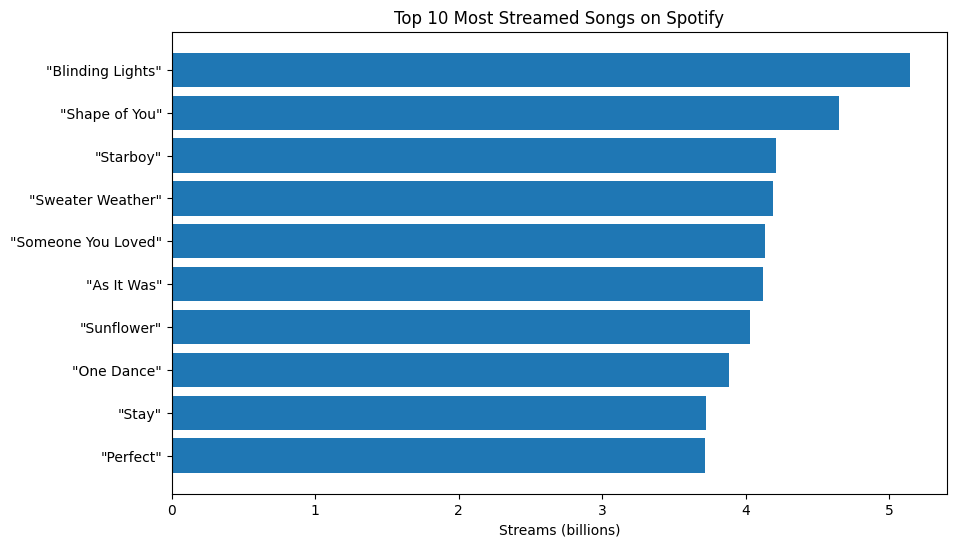

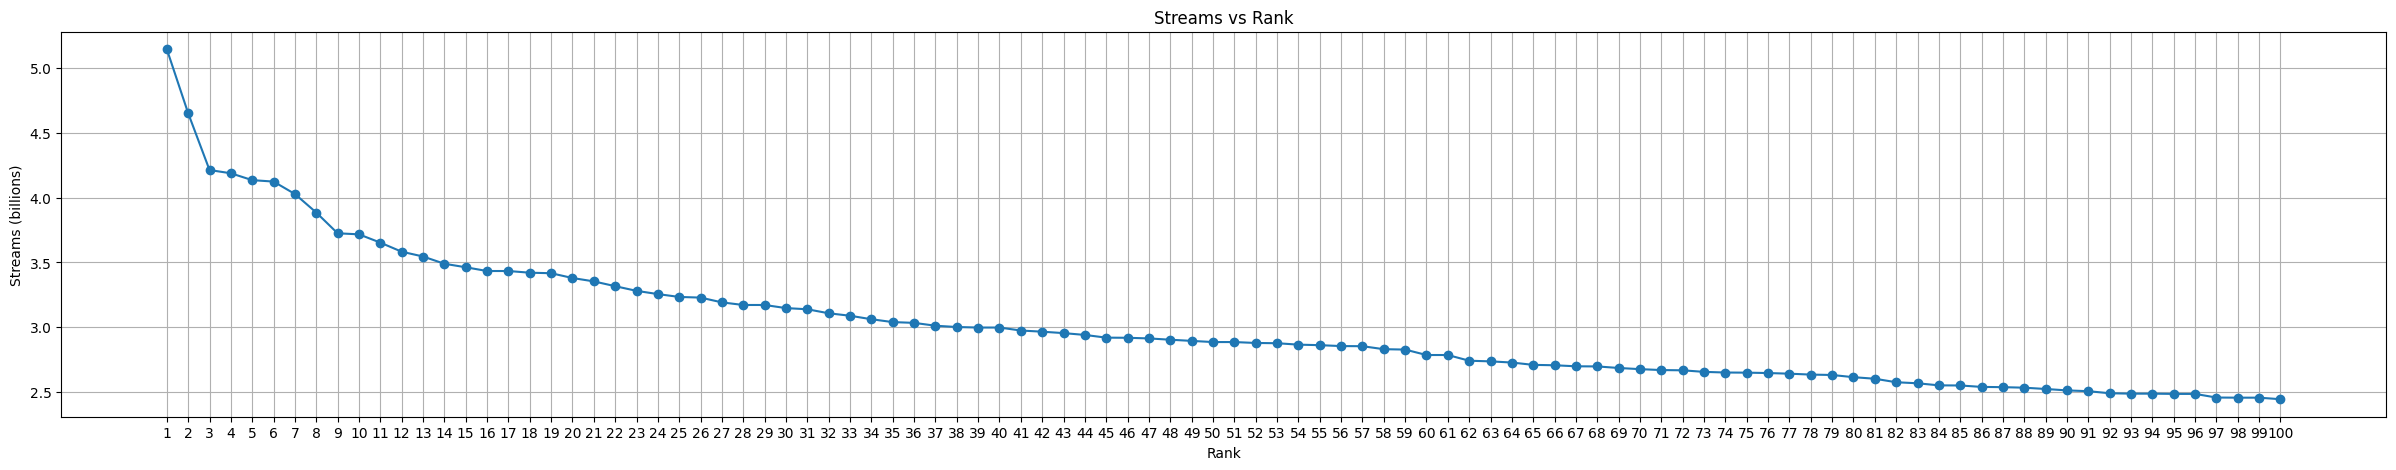

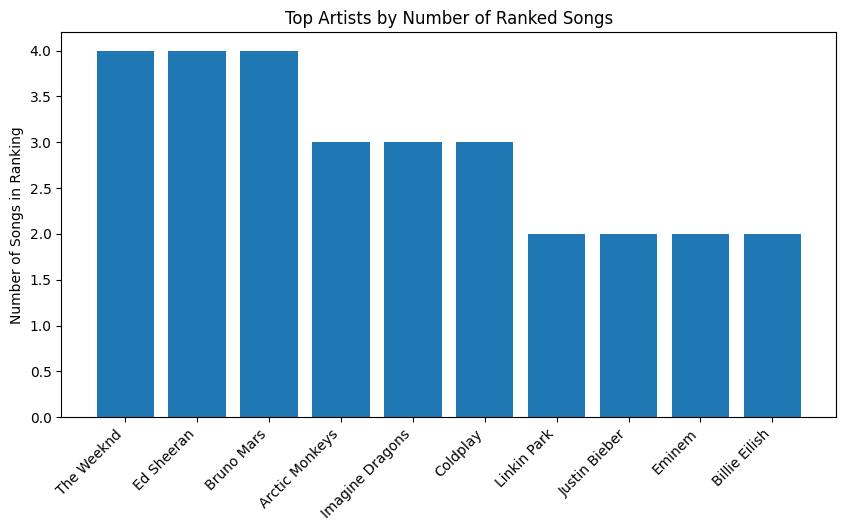

In [10]:
# ===============================================================
# STEP 6 - DATA VISUALIZATION
# ===============================================================
print("\n==============================================")
print("STEP 6 - DATA VISUALIZATION")
print("==============================================\n")

# TOP 10 in streams
top10 = selected_df.sort_values("Streams_billions_", ascending=False).head(10)
plt.figure(figsize=(10,6))
plt.barh(top10["Song"], top10["Streams_billions_"])
plt.xlabel("Streams (billions)")
plt.title("Top 10 Most Streamed Songs on Spotify")
plt.gca().invert_yaxis()
plt.show()

# Streams vs Rank
plt.figure(figsize=(30,5))
plt.plot(selected_df["Rank"], selected_df["Streams_billions_"], marker="o")
plt.xlabel("Rank")
plt.ylabel("Streams (billions)")
plt.title("Streams vs Rank")
plt.grid(True)
plt.show()

# Artits with most number of songs ranked
artist_counts = selected_df["Artist_s_"].value_counts().head(10)
plt.figure(figsize=(10,5))
plt.bar(artist_counts.index, artist_counts.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("Number of Songs in Ranking")
plt.title("Top Artists by Number of Ranked Songs")
plt.show()
